<a href="https://colab.research.google.com/github/sam-h-bean/imdb-goof/blob/master/lstm_imdb_self_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDb Sentiment Analysis Goof

## Import dependencies

In [39]:
import keras
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional

import matplotlib.pyplot as plt

### Constants

In [42]:
max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
embedding_dimmension = 32
lstm_units = 32
training_set_size = 25000
steps_per_epoch = training_set_size // batch_size

### Load IMDb

In [4]:
print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
17473536/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nda

25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


### Define and train the model

In [ ]:
inputs = keras.Input(shape=(maxlen,))
x = keras.layers.Embedding(input_dim=max_features, output_dim=embedding_dimmension)(inputs)
x = keras.layers.MultiHeadAttention(num_heads=5, key_dim=embedding_dimmension, dropout=0.1)(x, x)
x = keras.layers.Bidirectional(keras.layers.LSTM(units=lstm_units, dropout=0.2))(x)
x = keras.layers.LayerNormalization()(x)
x = keras.layers.Dense(units=100, activation='sigmoid')(x)
x = keras.layers.Dropout(rate=0.5)(x)
outputs = keras.layers.Dense(units=1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

print(model.summary())

optimizer=keras.optimizers.Adam(amsgrad=True)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
reduce_learning_rate = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=3)
callbacks = [early_stopping, reduce_learning_rate]
history = model.fit(input_train, y_train,
                    epochs=100,
                    batch_size=128,
                    validation_split=0.0,
                    callbacks=callbacks)

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_29 (Embedding)        (None, 500, 32)      320000      input_30[0][0]                   
__________________________________________________________________________________________________
multi_head_attention_29 (MultiH (None, 500, 32)      20992       embedding_29[0][0]               
                                                                 embedding_29[0][0]               
__________________________________________________________________________________________________
bidirectional_22 (Bidirectional (None, 64)           16640       multi_head_attention_29[0]

# Evaluate on test set

In [46]:
scores = model.evaluate(input_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 88.92%


## Plot results

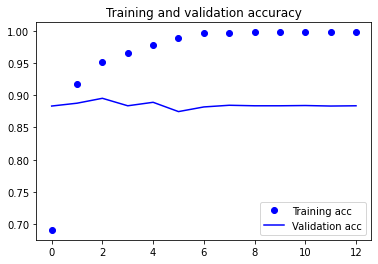

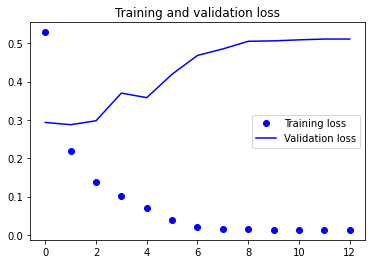

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()